<a href="https://colab.research.google.com/github/debu-sinha/building-ai-agents/blob/main/Reflection_based_Summary_Chatbot_with_Reviewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries

In [ ]:
!pip install langchain
!pip install langchain-openai
!pip install langgraph
!pip install pypdf

# Setup our Summarizer and Reviewer models

In [ ]:
from langchain_openai import ChatOpenAI
from google.colab import userdata

summarizer_model = ChatOpenAI(model_name="gpt-4o-mini", openai_api_key=userdata.get('oai'))
print(summarizer_model.invoke("Hello world!"))

reviewer_model = ChatOpenAI(model_name="gpt-4o", openai_api_key=userdata.get('oai'))
print(reviewer_model.invoke("Hello world!"))

content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 10, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CKnU3xuApRQBuRdM1vVDFM62oTuNX', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--dd9ac7c8-5c60-4130-bf27-b1f7b1fa2beb-0' usage_metadata={'input_tokens': 10, 'output_tokens': 9, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 10, 'total_tokens': 19, 'c

## Define the system prompts

In [ ]:
summarizer_prompt="""
You are an document summarizer who can summarize a document provide to you.
For the input provided, create a summary with less than 50 words.
If the user has provides critique, responsed with a revised version of your previous attempts
"""

reviewer_prompt="""
You are a reviewer grading summaries for an article.
Compare the user input document and generated summary.
Check if the summary accurately reflects the contents of the document.
Provide recommendations for improvement in less than 50 words.
"""

## Defining our langgraph agent with State management


In [45]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage

class Chat_Summarizer_Agent_State(TypedDict):
  messages: Annotated[list[AnyMessage], operator.add]

class Summarizer_Chatbot:
  def __init__(self, summarizer_model, reviewer_model, summarizer_system_prompt, reviewer_system_prompt, debug):
    self.summarizer_model = summarizer_model
    self.reviewer_model = reviewer_model
    self.summarizer_system_prompt = summarizer_system_prompt
    self.reviewer_system_prompt = reviewer_system_prompt
    self.debug = debug

    agent_graph = StateGraph(Chat_Summarizer_Agent_State)
    agent_graph.add_node("summarizer", self.call_summarizer)
    agent_graph.add_node("reviewer", self.call_reviewer)

    agent_graph.add_conditional_edges("summarizer",
                                      self.should_continue,
                                      {True: "reviewer", False: END})
    agent_graph.add_edge("reviewer", "summarizer")
    agent_graph.set_entry_point("summarizer")

    memory = MemorySaver()

    self.agent = agent_graph.compile(checkpointer=memory)

  def call_summarizer(self, state: Chat_Summarizer_Agent_State):
    # Read messages from the state and prepend the prompt
    messages = [SystemMessage(content=self.summarizer_system_prompt)] + state["messages"]
    response = self.summarizer_model.invoke(messages)

    if self.debug:
      print(f"Summarizer: {response.content}")
    return {"messages": [response]}

  def call_reviewer(self, state: Chat_Summarizer_Agent_State):
    # Read messages from the state and prepend the prompt
    messages = [SystemMessage(content=self.reviewer_system_prompt)] + state["messages"]
    response = self.reviewer_model.invoke(messages)

    if self.debug:
      print(f"********************************** \n Reviewer: {response.content}")
    return {"messages": [response]}

  def should_continue(self, state: Chat_Summarizer_Agent_State):
    total_reviews = len(state["messages"])
    if self.debug:
      print(f"Iteration Number: \n {total_reviews/2}")

    if total_reviews / 2 > 4:
      return False
    else:
      return True


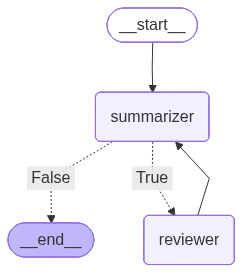

In [46]:
from IPython.display import Image
from langchain_community.document_loaders import PyPDFLoader

# Setup the summary chatbot
summary_chatbot = Summarizer_Chatbot(summarizer_model,
                                     reviewer_model,
                               summarizer_prompt,
                               reviewer_prompt,
                               debug=True)

Image(summary_chatbot.agent.get_graph().draw_mermaid_png())

# Test our Agent

In [47]:
# Input file for execution
# Load, chunk and index the contents of the pdf.
loader=PyPDFLoader("./data/EcoSprint_Specification_Document.pdf")
docs = loader.load()

#Pick the first page of the doc as content
source_content=docs[0].page_content.replace("\n"," ")
print(f"Input :==============\n {source_content}\n")

Input :==============
 EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandresponsivedrivingexperience.● Ba

In [48]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
messages=[HumanMessage(content=source_content)]
result=summary_chatbot.agent.invoke({"messages":messages},config)

Summarizer: The EcoSprint is an advanced electric vehicle designed for efficiency and performance, featuring a sleek design, spacious luxury interior, and a powerful 200-horsepower motor. It offers up to 250 miles of range, smart technology, and comprehensive safety features, making it ideal for eco-conscious urban drivers.
Iteration Number: 
 1.0
********************************** 
 Reviewer: The summary accurately captures the document's essence but misses specific details like selectable colors and acceleration. Including these minor yet notable points could enhance the summary's completeness. Consider emphasizing its unique blend of style, sustainability, and innovation to appeal to potential users better.
Summarizer: The EcoSprint is a revolutionary electric vehicle that combines efficiency and performance with sleek design. It offers seating for five, a powerful 200-horsepower motor, up to 250 miles of range, and advanced technology features, making it ideal for eco-conscious urb

# Add Human feedback element

In [49]:
summary_chatbot = Summarizer_Chatbot(summarizer_model,
                                     reviewer_model,
                               summarizer_prompt,
                               reviewer_prompt,
                               debug=False)

# Adding user feedback
user_inputs = [
    source_content,
    "Can you rewrite the review by focusing more on the specifications?",
    "Can you remove details about the touchscreen?"
]

#Create a new thread
config = {"configurable": {"thread_id": "thread-summarizer"}}

#Given the number of iterations, this will take a long time.
for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = summary_chatbot.agent.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")



----------------------------------------
USER : EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandrespons